In [36]:
import pandas as pd
from functools import reduce

import torch
from botorch.models import SingleTaskGP, HeteroskedasticSingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, LeaveOneOut

from gpytorch.kernels import RBFKernel
from gpytorch.constraints import Interval
from botorch.settings import validate_input_scaling,debug

from itertools import product

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double
bounds = torch.tensor([[0., 0.], [1., 1.]], dtype=dtype, device=device)

cuda


In [38]:
validate_input_scaling(state=False)
debug(state=False)

In [39]:
def r2_score_numpy(y_true, y_pred):
    """
    Calculate the R-squared score.

    Parameters:
    y_true (np.array): Actual values of the dependent variable.
    y_pred (np.array): Predicted values from the regression model.

    Returns:
    float: The R-squared score.
    """
    # Mean of observed data
    y_mean = np.mean(y_true)
    
    # Total sum of squares
    SS_tot = np.sum((y_true - y_mean) ** 2)
    
    # Residual sum of squares
    SS_res = np.sum((y_true - y_pred) ** 2)
    
    # Calculate R^2
    R2 = 1 - (SS_res / SS_tot)
    
    return R2

In [40]:
batch_corrected_mean=pd.read_csv("SurfactinC_mean.csv")

In [41]:
batch_corrected_mean

,Batch_SampleType,SurfactinC
0,0_1,0.980411
1,0_2,0.952564
2,0_3,0.961606
3,0_4,0.981018
4,0_5,0.758335
5,0_6,0.939234
6,0_7,1.019104
7,0_CTRL,0.649958
8,0_QC,1.000000
9,0_REF,1.032145


In [42]:
batch_corrected_mean=batch_corrected_mean[~batch_corrected_mean["Batch_SampleType"].apply(lambda x: ("CTRL" in x) or ("QC" in x) or ("REF" in x))]
batch_corrected_mean=batch_corrected_mean.rename({"Batch_SampleType":"sample","SurfactinC":"mean"},axis=1)

In [43]:
batch_corrected_var=pd.read_csv("SurfactinC_sem.csv")

In [44]:
atch_corrected_var=batch_corrected_var[~batch_corrected_var["Batch_SampleType"].apply(lambda x: ("CTRL" in x) or ("QC" in x) or ("REF" in x))]
batch_corrected_var=batch_corrected_var.rename({"Batch_SampleType":"sample","SurfactinC":"sem"},axis=1)

In [45]:
allsamples=reduce(lambda x,y: pd.concat([x,y]),[pd.read_csv(str(i)+"_samples.csv") for i in range(0,6)])
 

In [46]:
mean1=pd.merge(allsamples,batch_corrected_mean, how='left', on="sample")

In [47]:
mean_var=pd.merge(mean1,batch_corrected_var, how='left', on="sample")

In [48]:
table_sim=mean_var[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl','mean','sem']]
#x_numpy=mean_var[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values
#y_numpy=mean_var['mean'].values
#var_numpy=mean_var['var'].values

In [49]:
table_sim.to_csv("table_for_modelling.csv",index=False)
#table_sim.to_csv("table_for_modelling_no_log.csv",index=False)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_triangle_contour(data, columns, z_var='mean', file_path='contour_plots.png'):
    # Number of variables
    n = len(columns)
    fig, axs = plt.subplots(n, n, figsize=(20, 15))
    
    for i in range(n):
        for j in range(i + 1, n):
            # Prepare grid data for contour plot
            x = data[columns[i]]
            y = data[columns[j]]
            z = data[z_var]
            
            # Create grid points
            xi = np.linspace(x.min(), x.max(), 100)
            yi = np.linspace(y.min(), y.max(), 100)
            xi, yi = np.meshgrid(xi, yi)
            
            # Interpolate z values on this grid
            zi = griddata((x, y), z, (xi, yi), method='cubic')
            
            # Plotting on the correct subplot
            ax = axs[j][i]
            contour = ax.contourf(xi, yi, zi, levels=15, cmap='rainbow')
            fig.colorbar(contour, ax=ax)
            ax.set_xlabel(columns[i])
            ax.set_ylabel(columns[j])
            ax.set_title(f'{columns[i]} vs {columns[j]}')

    # Hide unused subplots
    for i in range(n):
        for j in range(n):
            if i < j:
                axs[i][j].axis('off')
            elif i == j:
                axs[i][j].axis('off')

    plt.tight_layout()
    plt.savefig(file_path,dpi=300)
    plt.close()



# Columns of interest for plotting
columns = ['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']

# Generate and save the contour plots
plot_triangle_contour(table_sim, columns)

In [51]:
train_x = torch.from_numpy(mean_var[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values).to(device=device, dtype=dtype)
train_y = torch.from_numpy(mean_var['mean'].values).reshape(-1,1).to(device=device, dtype=dtype)
y_var=torch.from_numpy(mean_var['sem'].values).reshape(-1,1).to(device=device, dtype=dtype)

In [52]:
gp_model = HeteroskedasticSingleTaskGP(train_x, train_y,y_var)

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9677], device='cuda:0', dtype=torch.float64), std = tensor([0.0634], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0351], device='cuda:0', dtype=torch.float64), std = tensor([0.0703], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [63]:
empirical_lengthscales=torch.tensor([0.3,0.3,0.3,0.3,0.3,0.3,0.3]).to(device=device,dtype=dtype)
upper_empirical_lengthscales=torch.tensor([1,1,1,1,1,1,1]).to(device=device,dtype=dtype)

In [64]:
#gp_model.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(0.7, 1))
gp_model.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(empirical_lengthscales,upper_empirical_lengthscales))


In [65]:
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): _GaussianLikelihoodBase(
    (noise_covar): HeteroskedasticNoise(
      (noise_model): SingleTaskGP(
        (likelihood): GaussianLikelihood(
          (noise_covar): HomoskedasticNoise(
            (noise_prior): SmoothedBoxPrior()
            (raw_noise_constraint): GreaterThan(1.000E-04)
          )
        )
        (mean_module): ConstantMean()
        (covar_module): ScaleKernel(
          (base_kernel): MaternKernel(
            (lengthscale_prior): GammaPrior()
            (raw_lengthscale_constraint): Positive()
          )
          (outputscale_prior): GammaPrior()
          (raw_outputscale_constraint): Positive()
        )
        (outcome_transform): Log()
      )
      (_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): HeteroskedasticSingleTaskGP(
    (likelihood): _GaussianLikelihoodBase(
      (noise_covar): HeteroskedasticNoise(
        (noise_model): SingleTaskGP(
          (likelihood): GaussianLikelihood(
 

In [66]:
gp_model.covar_module.base_kernel.lengthscale

tensor([[0.3000, 1.0000, 1.0000, 1.0000, 0.4735, 0.3000, 1.0000]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

rbf_kernel = RBFKernel(
        ard_num_dims=num_dims,
        lengthscale_constraint=Interval(
            torch.tensor(empirical_lengthscales, dtype=torch.float32),
            torch.tensor(empirical_lengthscales+0.01, dtype=torch.float32),
            ),
        )
gp_kernel = ScaleKernel(rbf_kernel)
gp = FixedNoiseGP(feature_pt, objective_pt, train_Yvar=objective_var_pt,
                      covar_module=gp_kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
ret = fit_gpytorch_mll(mll)

In [67]:
with torch.no_grad():
    predictive_posterior = mll.model.posterior(train_x, observation_noise=True)
    predictions = predictive_posterior.mean
    pre2=predictions.reshape(1,-1).cpu().numpy()

In [68]:
r2_score(train_y.cpu().numpy().reshape(1,-1)[0],pre2[0])

0.389295508362943

In [69]:
r2_score_numpy(train_y.cpu().numpy().reshape(1,-1)[0],pre2[0])

0.389295508362943

In [70]:
for_excel=pd.DataFrame({"y_true":train_y.cpu().numpy().reshape(1,-1)[0],"y_pred":pre2[0]})

In [71]:
for_excel.to_excel("compare.xlsx",index=False)

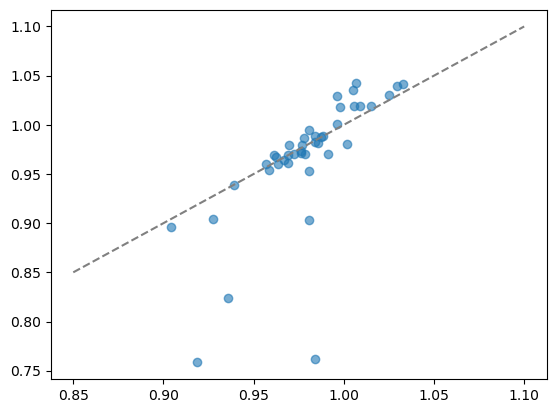

In [72]:
ideal_line = np.linspace(0.85, 1.1, 100)  # Ideal case line
plt.scatter(pre2[0],train_y.cpu().numpy().reshape(1,-1)[0],alpha=0.6)

plt.plot(ideal_line, ideal_line, '--', color='gray', label='Ideal case')

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9731], device='cuda:0', dtype=torch.float64), std = tensor([0.0576], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0291], device='cuda:0', dtype=torch.float64), std = tensor([0.0629], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.3001, 0.3001, 0.3005, 0.3006, 0.3004, 0.3007, 0.3024]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
[0.97277594 0.97093152 0.96988226 0.97527102 0.98592621 0.97027939] [0.75833502 0.93923367 0.96010414 0.9822242  1.01892597 0.95443645]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9668], device='cuda:0', dtype=torch.float64), std = tensor([0.0673], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0364], device='cuda:0', dtype=torch.float64), std = tensor([0.0747], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.3000, 0.3000, 0.3008, 0.3000, 0.3001, 0.3000, 0.3001]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
[0.96099387 0.96533681 0.96830065 0.95687605 0.97063482 0.9344063 ] [0.98797062 0.98912089 0.97952266 1.00072567 0.90413615 0.97928039]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9732], device='cuda:0', dtype=torch.float64), std = tensor([0.0629], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0294], device='cuda:0', dtype=torch.float64), std = tensor([0.0700], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.3000, 0.3000, 0.3006, 0.3000, 0.3000, 0.3000, 0.3000]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
[0.97594399 0.96810097 0.97777383 0.9740359  0.96493251 0.9684075 ] [0.98041091 0.96160559 0.97111999 0.96917828 0.8242616  0.9029714 ]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9707], device='cuda:0', dtype=torch.float64), std = tensor([0.0582], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0316], device='cuda:0', dtype=torch.float64), std = tensor([0.0637], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.3000, 0.5394, 0.5931, 0.3000, 0.4757, 0.4899, 0.5537]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
[0.95915862 0.9670858  0.97050107 0.9734635  1.00444497 0.97283397] [0.98101779 0.99431654 0.96984745 0.97353524 0.7621574  1.01941407]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9662], device='cuda:0', dtype=torch.float64), std = tensor([0.0654], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0369], device='cuda:0', dtype=torch.float64), std = tensor([0.0730], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.3000, 0.3001, 0.3001, 0.3000, 0.3000, 0.3000, 0.3001]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
[0.97425479 0.97322559 0.97631872 0.98158572 0.97240953 0.97624383] [1.03940701 0.96682759 0.96045664 1.03572434 0.89580908 0.96455416]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9624], device='cuda:0', dtype=torch.float64), std = tensor([0.0658], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0409], device='cuda:0', dtype=torch.float64), std = tensor([0.0733], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.3000, 0.3002, 0.3026, 0.3000, 0.3000, 0.3002, 0.3003]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
[0.97681807 0.97427571 0.97127134 0.9793811  0.9741546  0.97689779] [1.04204573 1.03016166 0.97014686 1.01812687 0.96941254 0.97052393]


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.9619], device='cuda:0', dtype=torch.float64), std = tensor([0.0656], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.0414], device='cuda:0', dtype=torch.float64), std = tensor([0.0731], device='cuda:0', dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


tensor([[0.3000, 0.3001, 0.3013, 0.3000, 0.3002, 0.3001, 0.3003]],
       device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
[0.97526449 0.97689088 0.97467022 0.97935489 0.97364946 0.97251564] [0.95256419 1.01910435 1.04196757 1.02908645 0.9887324  0.98688739]


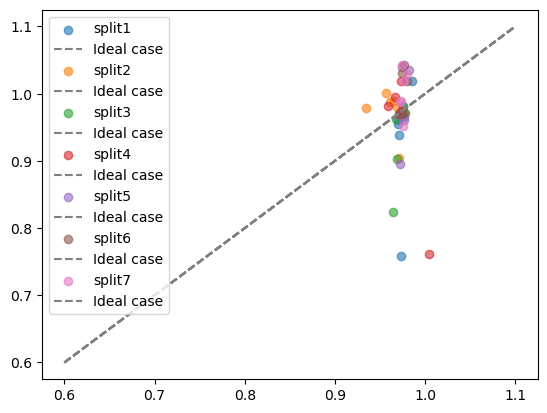

In [73]:
#samples = table_sim.shape[0]
kf = KFold(n_splits=7, shuffle=True)#, random_state=42) #LOO is equal to k-fold when k is the total number of samples

rmse_scores = []
r2list=[]
count=0
for train_index, test_index in kf.split(table_sim):
    # Splitting the data
    train, test = table_sim.iloc[train_index], table_sim.iloc[test_index]

    # Feature scaling
    #scaler = StandardScaler().fit(train[["Glucose", "NH4Cl"]].values)
    train_x = torch.from_numpy(train[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values).to(device=device,dtype=dtype)
    test_x = torch.from_numpy(test[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2','NaCl']].values).to(device=device,dtype=dtype)

    # Preparing target variables
    train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1).to(device=device,dtype=dtype)
    test_y = test["mean"].values.reshape(1,-1)[0]

    # Preparing observed variance
    observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1).to(device=device,dtype=dtype)

    # Model training
    model1 = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
    defined_lengthscales=torch.tensor([0.3,0.3,0.3,0.3,0.3,0.3,0.3]).to(device=device,dtype=dtype)
    upper_defined_lengthscales=torch.tensor([1,1,1,1,1,1,1]).to(device=device,dtype=dtype)
    
    model1.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(defined_lengthscales,upper_defined_lengthscales))
    #model1.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(0.9, 1))
    mll1 = ExactMarginalLogLikelihood(model1.likelihood, model1)
    fit_gpytorch_model(mll1)

    

    print(model1.covar_module.base_kernel.lengthscale)

    with torch.no_grad():
        predictive_posterior = mll1.model.posterior(test_x, observation_noise=True)
        predictions = predictive_posterior.mean
        pre2=predictions.reshape(1,-1).cpu().numpy()
        rsme = np.sqrt(np.mean((pre2[0] - test_y) ** 2))
        print(pre2[0],test_y)
        r2sc=r2_score_numpy(test_y,pre2[0])
    
    ideal_line = np.linspace(0.6, 1.1, 100)  # Ideal case line
    plt.scatter(pre2[0],test_y,alpha=0.6,label="split"+str(count+1))
    plt.plot(ideal_line, ideal_line, '--', color='gray', label='Ideal case')
    plt.legend()
    r2list.append(r2sc)  
    rmse_scores.append(rsme.item())
    count=count+1
    del model1,mll1

In [74]:
r2list

[-0.16780355260655022,
 -0.6093551650646409,
 -0.3058879665037513,
 -0.41193573728973853,
 0.06874134981305813,
 -0.5685493409700833,
 -0.7809747622208423]

In [90]:
# Define device and dtype for PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

# Initialize KFold
kf = KFold(n_splits=7, shuffle=True)

# Grid of lengthscales
lengthscale_grid = torch.arange(0.3, 0.9, 0.1).tolist()

# Storage for results
all_rmse_scores = []
all_r2_scores = []

# Iterate over each lengthscale configuration
for lengthscale_value in lengthscale_grid:
    # Prepare lists for storing scores for current lengthscale
    rmse_scores = []
    r2_scores = []

    # Perform cross-validation
    for train_index, test_index in kf.split(table_sim):
        # Splitting the data
        train, test = table_sim.iloc[train_index], table_sim.iloc[test_index]

        # Convert data to PyTorch tensors
        train_x = torch.from_numpy(train[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']].values).to(device=device, dtype=dtype)
        test_x = torch.from_numpy(test[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']].values).to(device=device, dtype=dtype)
        train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1).to(device=device, dtype=dtype)
        test_y = test["mean"].values.reshape(1, -1)[0]
        observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1).to(device=device, dtype=dtype)

        # Setup the model with current lengthscale
        model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
        defined_lengthscales = torch.tensor([lengthscale_value] * 7).to(device=device, dtype=dtype)
        model.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(defined_lengthscales, defined_lengthscales + 0.1))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # Predict and calculate metrics
        with torch.no_grad():
            predictive_posterior = mll.model.posterior(test_x, observation_noise=True)
            predictions = predictive_posterior.mean
            predictions = predictions.reshape(1, -1).cpu().numpy()[0]
            rmse = np.sqrt(np.mean((predictions - test_y) ** 2))
            r2sc = r2_score_numpy(test_y, predictions)

        # Append scores
        rmse_scores.append(rmse)
        r2_scores.append(r2sc)

        # Clean up
        del model, mll

    # Store results for all folds for current lengthscale
    all_rmse_scores.append(rmse_scores)
    all_r2_scores.append(r2_scores)

# After all configurations and splits have been processed, you can analyze `all_rmse_scores` and `all_r2_scores`

/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/gp_regression.py:298: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=train_X, Y=train_Y, Yvar=train_Yvar)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8888], device='cuda:0'), std = tensor([0.4519], device='cuda:0')). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is s

KeyboardInterrupt: 

In [30]:
all_r2_scores

[[0.39501654401452513,
  0.12894448621592858,
  0.19018561145738466,
  0.014663746403535405,
  0.4453364742408056,
  -0.0012804192464792585,
  0.38370007141280205],
 [0.053224493339654955,
  0.508074382531067,
  -0.880525118532623,
  -0.21689741056501743,
  0.5499217985772987,
  0.12622166978644356,
  0.28323497193525815],
 [0.36599513998880295,
  -1.0763306280170828,
  0.1466639527012915,
  0.2019189160021272,
  0.22768399085717506,
  0.5602236174006172,
  0.33977731166155956],
 [0.32851538128684743,
  -0.5766098092670708,
  0.046205257449181136,
  0.15529895698185037,
  0.054522505751493755,
  -0.4894890088720265,
  -0.1995761639289757],
 [0.3391300266210897,
  0.14444088407080502,
  0.4201899412384159,
  0.39349014744749466,
  0.42852651136122855,
  -0.10471728753661469,
  0.4776819389299589]]

In [33]:
lengthscale_grid

[0.30000001192092896,
 0.4000000059604645,
 0.5,
 0.6000000238418579,
 0.699999988079071]

In [33]:
# Define device and dtype for PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

# Initialize KFold
kf = KFold(n_splits=7, shuffle=True)

# Define the range for lengthscales and prepare grid
lengthscale_range = torch.arange(0.3, 0.9, 0.3)
lengthscale_combinations = list(product(lengthscale_range, repeat=7))

In [35]:
# Storage for results
all_rmse_scores = []
all_r2_scores = []
all_lengthscales=[]

count=0
# Iterate over each combination of lengthscales
for lengthscales in lengthscale_combinations:
    print("Run"+str(count+1))
    # Prepare lists for storing scores for current combination
    rmse_scores = []
    r2_scores = []

    # Perform cross-validation
    for train_index, test_index in kf.split(table_sim):
        # Splitting the data
        train, test = table_sim.iloc[train_index], table_sim.iloc[test_index]

        # Convert data to PyTorch tensors
        train_x = torch.from_numpy(train[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']].values).to(device=device, dtype=dtype)
        test_x = torch.from_numpy(test[['Glucose', 'NH4Cl', 'MgSO4', 'KH2PO4', 'Na2HPO4', 'CaCl2', 'NaCl']].values).to(device=device, dtype=dtype)
        train_y = torch.from_numpy(train["mean"].values).reshape(-1, 1).to(device=device, dtype=dtype)
        test_y = test["mean"].values.reshape(1, -1)[0]
        observed_var = torch.from_numpy(train["sem"].values).reshape(-1, 1).to(device=device, dtype=dtype)

        # Setup the model with current lengthscales
        model = HeteroskedasticSingleTaskGP(train_X=train_x, train_Y=train_y, train_Yvar=observed_var)
        defined_lengthscales = torch.tensor(lengthscales).to(device=device, dtype=dtype)
        model.covar_module.base_kernel.register_constraint("raw_lengthscale", Interval(defined_lengthscales, defined_lengthscales + 0.3))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_model(mll)

        # Predict and calculate metrics
        with torch.no_grad():
            predictive_posterior = mll.model.posterior(test_x, observation_noise=True)
            predictions = predictive_posterior.mean
            predictions = predictions.reshape(1, -1).cpu().numpy()[0]
            rmse = np.sqrt(np.mean((predictions - test_y) ** 2))
            r2sc = r2_score_numpy(test_y, predictions)

        # Append scores
        rmse_scores.append(rmse)
        r2_scores.append(r2sc)

        # Clean up
        del model, mll

    # Store results for all folds for current lengthscale combination
    all_rmse_scores.append(rmse_scores)
    all_r2_scores.append(r2_scores)
    all_lengthscales.append(lengthscales)
    count=count+1

# After all configurations and splits have been processed, you can analyze `all_rmse_scores` and `all_r2_scores`

Run1


/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/gp_regression.py:298: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=train_X, Y=train_Y, Yvar=train_Yvar)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.8621], device='cuda:0'), std = tensor([0.4422], device='cuda:0')). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/rgvalenciaalbornoz/miniconda3/envs/botorch_mar2024/lib/python3.11/site-packages/botorch/models/gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is s

KeyboardInterrupt: 

In [34]:
len(lengthscale_combinations)

2187